# Analyzing Web Server Logs with Apache Spark

Apache Spark is an excellent and ideal framework for wrangling, analyzing and modeling on structured and unstructured data - at scale! In this mini-project, we will be focusing on one of the most popular use-cases in the industry - log analytics.

Typically, server logs are a very common data source in enterprises and often contain a gold mine of actionable insights and information. Log data comes from many sources in an enterprise, such as the web, client and compute servers, applications, user-generated content, flat files. They can be used for monitoring servers, improving business and customer intelligence, building recommendation systems, fraud detection, and much more.

Spark allows you to dump and store your logs in files on disk cheaply, while still providing rich APIs to perform data analysis at scale. This mini-project will show you how to use Apache Spark on real-world production logs from NASA and learn data wrangling and basic yet powerful techniques in exploratory data analysis.

There are a total of 12 questions for you to solve along with some interactive examples which will help you learn aspects of leveraging spark for analyzing over 3 million logs at scale.

Remember to focus on the __`# TODO: Replace <FILL IN> with appropriate code`__ sections to fill them up with necessary code to solve the desired questions in the notebook

# Section 1 - Loading up Dependencies

In [1]:
spark

In [2]:
sqlContext

In [3]:
if 'sc' not in locals():
    from pyspark.context import SparkContext
    from pyspark.sql.context import SQLContext
    from pyspark.sql.session import SparkSession
    
    sc = SparkContext()
    sqlContext = SQLContext(sc)
    spark = SparkSession(sc)

In [4]:
import re
import pandas as pd

In [5]:
m = re.finditer(r'.*?(spark).*?', "I'm searching for a spark in PySpark", re.I)
for match in m:
    print(match)
    print(match.group(0))
    

    m_list = re.findall(r'.*?(spark).*?', "I'm searching for a spark in PySpark", re.I)
for match in m_list:
    print(match)

<_sre.SRE_Match object; span=(0, 25), match="I'm searching for a spark">
I'm searching for a spark
<_sre.SRE_Match object; span=(25, 36), match=' in PySpark'>
 in PySpark
spark
Spark


For this mini-project, we will analyze datasets from NASA Kennedy Space Center web server in Florida. The full data set is freely available for download [__here__](http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html).

These two traces contain two month's worth of all HTTP requests to the NASA Kennedy Space Center WWW server in Florida. You can head over to the [__website__](http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html) and download the following files if needed OR just upload the files we have already provided for you into Domino's Cloud Platform (unless you plan to use Spark locally).

- Jul 01 to Jul 31, ASCII format, 20.7 MB gzip compressed, 205.2 MB uncompressed: [ftp://ita.ee.lbl.gov/traces/NASA_access_log_Jul95.gz](ftp://ita.ee.lbl.gov/traces/NASA_access_log_Jul95.gz)
- Aug 04 to Aug 31, ASCII format, 21.8 MB gzip compressed, 167.8 MB uncompressed: [ftp://ita.ee.lbl.gov/traces/NASA_access_log_Aug95.gz](ftp://ita.ee.lbl.gov/traces/NASA_access_log_Aug95.gz)

Make sure both the files are in the same directory as this notebook.

# Section 2 - Loading and Viewing the Log Dataset

Given that our data is stored in the following mentioned path, let's load it into a DataFrame. We'll do this in steps. First, we'll use `sqlContext.read.text()` or `spark.read.text()` to read the text file. This will produce a DataFrame with a single string column called `value`.

In [6]:
import glob

raw_data_files = glob.glob('*.gz')
raw_data_files

['NASA_access_log_Jul95.gz', 'NASA_access_log_Aug95.gz']

### Taking a look at the metadata of our dataframe

In [7]:
base_df = spark.read.text(raw_data_files)
base_df.printSchema()

root
 |-- value: string (nullable = true)



In [8]:
base_df.head(4)

[Row(value='199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245'),
 Row(value='unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985'),
 Row(value='199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0')]

In [9]:
type(base_df)

pyspark.sql.dataframe.DataFrame

You can also convert a dataframe to an RDD if needed

In [10]:
base_df_rdd = base_df.rdd
type(base_df_rdd)

pyspark.rdd.RDD

### Viewing sample data in our dataframe
Looks like it needs to be wrangled and parsed!

In [11]:
base_df.show(10, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                  |
+-----------------------------------------------------------------------------------------------------------------------+
|199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245                                 |
|unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985                      |
|199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085   |
|burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0               |
|199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179|
|burger.letters.com - - 

Getting data from an RDD is slightly different. You can see how the data representation is different in the following RDD

In [12]:
base_df_rdd.take(10)

[Row(value='199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245'),
 Row(value='unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985'),
 Row(value='199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0'),
 Row(value='199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0" 304 0'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/video/livevideo.gif HTTP/1.0" 200 0'),
 Row(value='205.212.115.106 - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/countdown.html HTTP/1.0" 200 3985'),
 Row(value='d104.aa.net - - [01/Ju

# Section 3 - Data Wrangling

In this section, we will try and clean and parse our log dataset to really extract structured attributes with meaningful information from each log message.

### Data understanding
If you're familiar with web server logs, you'll recognize that the above displayed data is in [Common Log Format](https://www.w3.org/Daemon/User/Config/Logging.html#common-logfile-format). 

The fields are:
__`remotehost rfc931 authuser [date] "request" status bytes`__


| field         | meaning                                                                |
| ------------- | ---------------------------------------------------------------------- |
| _remotehost_  | Remote hostname (or IP number if DNS hostname is not available or if [DNSLookup](https://www.w3.org/Daemon/User/Config/General.html#DNSLookup) is off).       |
| _rfc931_      | The remote logname of the user if at all it is present. |
| _authuser_    | The username of the remote user after authentication by the HTTP server.  |
| _[date]_      | Date and time of the request.                                      |
| _"request"_   | The request, exactly as it came from the browser or client.            |
| _status_      | The [HTTP status code](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes) the server sent back to the client.               |
| _bytes_       | The number of bytes (`Content-Length`) transferred to the client.      |

We will need to use some specific techniques to parse, match and extract these attributes from the log data

## Data Parsing and Extraction with Regular Expressions

Next, we have to parse it into individual columns. We'll use the special built-in [regexp\_extract()](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.regexp_extract)
function to do the parsing. This function matches a column against a regular expression with one or more [capture groups](http://regexone.com/lesson/capturing_groups) and allows you to extract one of the matched groups. We'll use one regular expression for each field we wish to extract.

You must have heard or used a fair bit of regular expressions by now. If you find regular expressions confusing (and they certainly _can_ be), and you want to learn more about them, we recommend checking out the
[RegexOne web site](http://regexone.com/). You might also find [_Regular Expressions Cookbook_](http://shop.oreilly.com/product/0636920023630.do), by Goyvaerts and Levithan, to be useful as a reference.

#### Let's take a look at our dataset dimensions

In [13]:
print((base_df.count(), len(base_df.columns)))

(3461613, 1)


Let's extract and take a look at some sample log messages

In [14]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

['199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245',
 'unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985',
 '199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085',
 'burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0',
 '199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179',
 'burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0" 304 0',
 'burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/video/livevideo.gif HTTP/1.0" 200 0',
 '205.212.115.106 - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/countdown.html HTTP/1.0" 200 3985',
 'd104.aa.net - - [01/Jul/1995:00:00:13 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985',
 '129.94.144.152 - - [01/Jul/

### Extracting host names

Let's try and write some regular expressions to extract the host name from the logs

In [15]:
host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
hosts = [re.search(host_pattern, item).group(1)
           if re.search(host_pattern, item)
           else 'no match'
           for item in sample_logs]
hosts
# (^\S+\.[\S+\.]+\S+)  is the group 1

['199.72.81.55',
 'unicomp6.unicomp.net',
 '199.120.110.21',
 'burger.letters.com',
 '199.120.110.21',
 'burger.letters.com',
 'burger.letters.com',
 '205.212.115.106',
 'd104.aa.net',
 '129.94.144.152',
 'unicomp6.unicomp.net',
 'unicomp6.unicomp.net',
 'unicomp6.unicomp.net',
 'd104.aa.net',
 'd104.aa.net']

### Extracting timestamps 

Let's now try and use regular expressions to extract the timestamp fields from the logs

In [16]:
ts_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]'
timestamps = [re.search(ts_pattern, item).group(1) for item in sample_logs]
timestamps # server specific time format

['01/Jul/1995:00:00:01 -0400',
 '01/Jul/1995:00:00:06 -0400',
 '01/Jul/1995:00:00:09 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:12 -0400',
 '01/Jul/1995:00:00:13 -0400',
 '01/Jul/1995:00:00:13 -0400',
 '01/Jul/1995:00:00:14 -0400',
 '01/Jul/1995:00:00:14 -0400',
 '01/Jul/1995:00:00:14 -0400',
 '01/Jul/1995:00:00:15 -0400',
 '01/Jul/1995:00:00:15 -0400']

### Extracting HTTP Request Method, URIs and Protocol 

Let's now try and use regular expressions to extract the HTTP request methods, URIs and Protocol patterns fields from the logs

In [17]:
method_uri_protocol_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
method_uri_protocol = [re.search(method_uri_protocol_pattern, item).groups()
               if re.search(method_uri_protocol_pattern, item)
               else 'no match'
              for item in sample_logs]
method_uri_protocol  # because the request & protocol is within the double quote 

[('GET', '/history/apollo/', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/', 'HTTP/1.0'),
 ('GET', '/shuttle/missions/sts-73/mission-sts-73.html', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/liftoff.html', 'HTTP/1.0'),
 ('GET', '/shuttle/missions/sts-73/sts-73-patch-small.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/video/livevideo.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/countdown.html', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/', 'HTTP/1.0'),
 ('GET', '/', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/count.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/images/KSC-logosmall.gif', 'HTTP/1.0'),
 ('GET', '/shuttle/countdown/count.gif', 'HTTP/1.0'),
 ('GET', '/images/NASA-logosmall.gif', 'HTTP/1.0')]

In [18]:
for item in method_uri_protocol[0]:
    print(item)

GET
/history/apollo/
HTTP/1.0


### Building an intermediate parsed dataframe

Let's try and use our regular expressions we have implemented so far into parsing and extracting the relevant entities in separate columns in a new dataframe

In [19]:
from pyspark.sql.functions import regexp_extract

logs_df = base_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'))
logs_df.show(10, truncate=False)
print((logs_df.count(), len(logs_df.columns)))

+--------------------+--------------------------+------+-----------------------------------------------+--------+
|host                |timestamp                 |method|endpoint                                       |protocol|
+--------------------+--------------------------+------+-----------------------------------------------+--------+
|199.72.81.55        |01/Jul/1995:00:00:01 -0400|GET   |/history/apollo/                               |HTTP/1.0|
|unicomp6.unicomp.net|01/Jul/1995:00:00:06 -0400|GET   |/shuttle/countdown/                            |HTTP/1.0|
|199.120.110.21      |01/Jul/1995:00:00:09 -0400|GET   |/shuttle/missions/sts-73/mission-sts-73.html   |HTTP/1.0|
|burger.letters.com  |01/Jul/1995:00:00:11 -0400|GET   |/shuttle/countdown/liftoff.html                |HTTP/1.0|
|199.120.110.21      |01/Jul/1995:00:00:11 -0400|GET   |/shuttle/missions/sts-73/sts-73-patch-small.gif|HTTP/1.0|
|burger.letters.com  |01/Jul/1995:00:00:12 -0400|GET   |/images/NASA-logosmall.gif      

### Extracting HTTP Status Codes

Let's now try and use regular expressions to extract the HTTP status codes from the logs

In [20]:
status_pattern = r'\s(\d{3})\s'
status = [re.search(status_pattern, item).group(1) for item in sample_logs]
print(status) # response is 3 digit web response code

['200', '200', '200', '304', '200', '304', '200', '200', '200', '200', '200', '200', '200', '200', '200']


### Extracting HTTP Response Content Size

Let's now try and use regular expressions to extract the HTTP response content size from the logs

In [21]:
content_size_pattern = r'\s(\d+)$'
content_size = [re.search(content_size_pattern, item).group(1) for item in sample_logs]
print(content_size) #size is at the tail of the log

['6245', '3985', '4085', '0', '4179', '0', '0', '3985', '3985', '7074', '40310', '786', '1204', '40310', '786']


## Q1: Your Turn: Putting it all together 

Let's now try and leverage all the regular expression patterns we previously built and use the `regexp_extract(...)` method to build our dataframe with all the log attributes neatly extracted in their own separate columns.

- You can reuse the code we used previously to build the intermediate dataframe
- Remember to cast the HTTP status code and content size as integers. 
- You can cast data as integer type using the following: __`regexp_extract('value', ...., ...).cast('integer').alias(...)`__

In [22]:
# TODO: Replace <FILL IN> with appropriate code

logs_df = base_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                         regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                         regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
logs_df.show(10, truncate=True)
print((logs_df.count(), len(logs_df.columns)))

+--------------------+--------------------+------+--------------------+--------+------+------------+
|                host|           timestamp|method|            endpoint|protocol|status|content_size|
+--------------------+--------------------+------+--------------------+--------+------+------------+
|        199.72.81.55|01/Jul/1995:00:00...|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|
|unicomp6.unicomp.net|01/Jul/1995:00:00...|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   200|    

## Finding Missing Values

Missing and null values are the bane of data analysis and machine learning. Let's see how well our data parsing and extraction logic worked. First, let's verify that there are no null rows in the original dataframe.

In [23]:
base_df.filter(base_df['value'].isNull()).count()

0

If our data parsing and extraction worked properly, we should not have any rows with potential null values. Let's try and put that to test!

In [24]:
bad_rows_df = logs_df.filter(logs_df['host'].isNull()| 
                             logs_df['timestamp'].isNull() | 
                             logs_df['method'].isNull() |
                             logs_df['endpoint'].isNull() |
                             logs_df['status'].isNull() |
                             logs_df['content_size'].isNull()|
                             logs_df['protocol'].isNull())
bad_rows_df.count()

33905

Ouch! Looks like we have over 30K missing values in our data! Can we handle this?

Do remember, this is not a regular pandas dataframe which you can directly query and get which columns have null. Our so-called _big dataset_ is residing on disk which can potentially be present in multiple nodes in a spark cluster. So how do we find out which columns have potential nulls? 

### Finding Null Counts

We can typically use the following technique to find out which columns have null values. 

(__Note:__ This approach is adapted from an [excellent answer](http://stackoverflow.com/a/33901312) on StackOverflow.)

In [25]:
logs_df.columns

['host',
 'timestamp',
 'method',
 'endpoint',
 'protocol',
 'status',
 'content_size']

In [26]:
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as spark_sum

def count_null(col_name):
    return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)

# Build up a list of column expressions, one per column.
exprs = [count_null(col_name) for col_name in logs_df.columns]

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     1|       33905|
+----+---------+------+--------+--------+------+------------+



Well, looks like we have one missing value in the `status` column and everything else is in the `content_size` column. 
Let's see if we can figure out what's wrong!

### Handling nulls in HTTP status

If you had solved it correctly, our original parsing regular expression for the `status` column was:

```
regexp_extract('value', r'\s(\d{3})\s', 1).cast('integer').alias('status')
``` 

Could it be that there are more digits making our regular expression wrong? or is the data point itself bad? Let's try and find out!

**Note**: In the expression below, `~` means "not".

In [27]:
null_status_df = base_df.filter(~base_df['value'].rlike(r'\s(\d{3})\s'))
null_status_df.count()

1

In [28]:
null_status_df.show(truncate=False)

+--------+
|value   |
+--------+
|alyssa.p|
+--------+



In [29]:
bad_status_df = null_status_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                                      regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                                      regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                                      regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                                      regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                                      regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                                      regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
bad_status_df.show(truncate=False)

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|    |         |      |        |        |null  |null        |
+----+---------+------+--------+--------+------+------------+



Looks like the record itself is an incomplete record with no useful information, the best option would be to drop this record as follows!

In [30]:
logs_df.count()

3461613

In [31]:
logs_df = logs_df[logs_df['status'].isNotNull()]
logs_df.count()

3461612

In [32]:
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|       33904|
+----+---------+------+--------+--------+------+------------+



### Handling nulls in HTTP content size

Again based on our previous regular expression and assuming you were able to solve it correctly, our original parsing regular expression for the `content_size` column was:

```
regexp_extract('value', r'\s(\d+)$', 1).cast('integer').alias('content_size')
``` 

Could there be missing data in our original dataset itself? Let's try and find out!

### Q2: Your Turn: Find out the records in our base data frame with potential missing content sizes

- Use the `r'\s\d+$'` regex pattern with the `rlike()` function like we demonstrated in the previous example
- Remember to work on `base_df` since we are searching on the raw records NOT the parsed `logs_df`
- Find the total count of the records with missing content size in `base_df` using the `count()` function

In [33]:
# TODO: Replace <FILL IN> with appropriate code

null_content_size_df = logs_df.filter(~base_df['value'].rlike(content_size_pattern))
null_content_size_df.count()

33904

### Q3: Your Turn: Display the top ten records of your data frame having missing content sizes

In [34]:
# TODO: Replace <FILL IN> with appropriate code

null_content_size_df.show(10)

+--------------------+--------------------+------+--------------------+--------+------+------------+
|                host|           timestamp|method|            endpoint|protocol|status|content_size|
+--------------------+--------------------+------+--------------------+--------+------+------------+
|dd15-062.compuser...|01/Jul/1995:00:01...|   GET|/news/sci.space.s...|HTTP/1.0|   404|        null|
|     dynip42.efn.org|01/Jul/1995:00:02...|   GET|           /software|HTTP/1.0|   302|        null|
|ix-or10-06.ix.net...|01/Jul/1995:00:02...|   GET|     /software/winvn|HTTP/1.0|   302|        null|
|ix-or10-06.ix.net...|01/Jul/1995:00:03...|   GET|           /software|HTTP/1.0|   302|        null|
|link097.txdirect.net|01/Jul/1995:00:05...|   GET|            /shuttle|HTTP/1.0|   302|        null|
|ix-war-mi1-20.ix....|01/Jul/1995:00:05...|   GET|/shuttle/missions...|HTTP/1.0|   302|        null|
|ix-war-mi1-20.ix....|01/Jul/1995:00:05...|   GET|/shuttle/missions...|HTTP/1.0|   302|    

Assuming you were able to get to the missing records above, it is quite evident that the bad raw data records correspond to error responses, where no content was sent back and the server emitted a "`-`" for the `content_size` field. 

Since we don't want to discard those rows from our analysis, let's impute or fill them to 0.

### Q4: Your Turn: Fix the rows with null content\_size

The easiest solution is to replace the null values in `logs_df` with 0 like we discussed earlier. The Spark DataFrame API provides a set of functions and fields specifically designed for working with null values, among them:

* [fillna()](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.fillna), which fills null values with specified non-null values.
* [na](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.na), which returns a [DataFrameNaFunctions](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameNaFunctions) object with many functions for operating on null columns.

There are several ways to invoke this function. The easiest is just to replace _all_ null columns with known values. But, for safety, it's better to pass a Python dictionary containing (column\_name, value) mappings. That's what we'll do. A sample example from the documentation is depicted below

```
>>> df4.na.fill({'age': 50, 'name': 'unknown'}).show()
+---+------+-------+
|age|height|   name|
+---+------+-------+
| 10|    80|  Alice|
|  5|  null|    Bob|
| 50|  null|    Tom|
| 50|  null|unknown|
+---+------+-------+
```

Now use this function and fill all the missing values in the `content_size` field with 0!

In [35]:
# TODO: Replace <FILL IN> with appropriate code

logs_df =logs_df.na.fill({'content_size': 0})
logs_df.count()

3461612

Now assuming you were able to fill in the missing values successfully in the previous question, we should have no missing values \ nulls in our dataset. Let's verify this!

In [36]:
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+



Look at that, no missing values! 

## Handling Temporal Fields (Timestamp)

Now that we have a clean, parsed DataFrame, we have to parse the timestamp field into an actual timestamp. The Common Log Format time is somewhat non-standard. A User-Defined Function (UDF) is the most straightforward way to parse it.

In [37]:
from pyspark.sql.functions import udf

month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(text):
    """ Convert Common Log time format into a Python datetime object
    Args:
        text (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
    """
    # NOTE: We're ignoring time zone here. In a production application, you'd want to handle that.
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(text[7:11]),
      month_map[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20])
    )

In [38]:
sample_ts = [item['timestamp'] for item in logs_df.select('timestamp').take(5)]
sample_ts

['01/Jul/1995:00:00:01 -0400',
 '01/Jul/1995:00:00:06 -0400',
 '01/Jul/1995:00:00:09 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:11 -0400']

In [39]:
[parse_clf_time(item) for item in sample_ts]

['1995-07-01 00:00:01',
 '1995-07-01 00:00:06',
 '1995-07-01 00:00:09',
 '1995-07-01 00:00:11',
 '1995-07-01 00:00:11']

In [40]:
udf_parse_time = udf(parse_clf_time)

logs_df = logs_df.select('*', udf_parse_time(logs_df['timestamp']).cast('timestamp').alias('time')).drop('timestamp')
logs_df.show(10, truncate=True)

+--------------------+------+--------------------+--------+------+------------+-------------------+
|                host|method|            endpoint|protocol|status|content_size|               time|
+--------------------+------+--------------------+--------+------+------------+-------------------+
|        199.72.81.55|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|1995-07-01 00:00:01|
|unicomp6.unicomp.net|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|1995-07-01 00:00:06|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|1995-07-01 00:00:09|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|1995-07-01 00:00:11|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|1995-07-01 00:00:11|
|  burger.letters.com|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|1995-07-01 00:00:12|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   200|           0|1995-07-01 00:00:12|


In [41]:
logs_df.printSchema()

root
 |-- host: string (nullable = true)
 |-- method: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- content_size: integer (nullable = false)
 |-- time: timestamp (nullable = true)



In [42]:
logs_df.limit(5).toPandas()

,host,method,endpoint,protocol,status,content_size,time
0,199.72.81.55,GET,/history/apollo/,HTTP/1.0,200,6245,1995-07-01 00:00:01
1,unicomp6.unicomp.net,GET,/shuttle/countdown/,HTTP/1.0,200,3985,1995-07-01 00:00:06
2,199.120.110.21,GET,/shuttle/missions/sts-73/mission-sts-73.html,HTTP/1.0,200,4085,1995-07-01 00:00:09
3,burger.letters.com,GET,/shuttle/countdown/liftoff.html,HTTP/1.0,304,0,1995-07-01 00:00:11
4,199.120.110.21,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,HTTP/1.0,200,4179,1995-07-01 00:00:11


Let's now cache `logs_df` since we will be using it extensively for our data analysis section in the next part!

In [43]:
logs_df.cache().storageLevel

StorageLevel(True, True, False, True, 1)

# Section 4 - Data Analysis on our Web Logs

Now that we have a DataFrame containing the parsed log file as a data frame, we can perform some interesting exploratory data analysis (EDA)

## Example: Content Size Statistics

Let's compute some statistics about the sizes of content being returned by the web server. In particular, we'd like to know what are the average, minimum, and maximum content sizes.

We can compute the statistics by calling `.describe()` on the `content_size` column of `logs_df`.  The `.describe()` function returns the count, mean, stddev, min, and max of a given column.

In [44]:
content_size_summary_df = logs_df.describe(['content_size'])
content_size_summary_df.toPandas()

,summary,content_size
0,count,3461612
1,mean,18928.844398216785
2,stddev,73031.47260949228
3,min,0
4,max,6823936


In [45]:
pandas_df = logs_df.toPandas()

In [46]:
pandas_df['content_size'].describe()

count    3.461612e+06
mean     1.892884e+04
std      7.303147e+04
min      0.000000e+00
25%      6.690000e+02
50%      3.584000e+03
75%      1.037100e+04
max      6.823936e+06
Name: content_size, dtype: float64

Alternatively, we can use SQL to directly calculate these statistics.  You can explore many useful functions within the `pyspark.sql.functions` module in the [documentation](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions).

After we apply the `.agg()` function, we call `toPandas()` to extract and convert the result into a `pandas` dataframe which has better formatting on Jupyter notebooks

In [47]:
from pyspark.sql import functions as F

(logs_df.agg(F.min(logs_df['content_size']).alias('min_content_size'),
             F.max(logs_df['content_size']).alias('max_content_size'),
             F.mean(logs_df['content_size']).alias('mean_content_size'),
             F.stddev(logs_df['content_size']).alias('std_content_size'),
             F.count(logs_df['content_size']).alias('count_content_size'))
        .toPandas())

,min_content_size,max_content_size,mean_content_size,std_content_size,count_content_size
0,0,6823936,18928.844398,73031.472609,3461612


## Example: HTTP Status Code Analysis

Next, let's look at the status code values that appear in the log. We want to know which status code values appear in the data and how many times.  

We again start with `logs_df`, then group by the `status` column, apply the `.count()` aggregation function, and sort by the `status` column.

In [72]:
status_freq_df = (logs_df
                     .groupBy('status')
                     .count()
                     .sort('status')
                     .cache())

In [73]:
print('Total distinct HTTP Status Codes:', status_freq_df.count())

Total distinct HTTP Status Codes: 8


In [74]:
status_freq_pd_df = status_freq_df.toPandas()
status_freq_pd_df

,status,count
0,200,3100524
1,302,73070
2,304,266773
3,400,15
4,403,225
5,404,20899
6,500,65
7,501,41


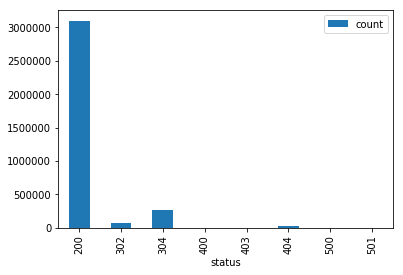

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

status_freq_pd_df.plot(x='status', y='count', kind='bar')

In [55]:
log_freq_df = status_freq_df.withColumn('log(count)', F.log(status_freq_df['count']))
log_freq_df.show()

+------+-------+------------------+
|status|  count|        log(count)|
+------+-------+------------------+
|   200|3100524|14.947081687429097|
|   302|  73070|11.199173164785263|
|   304| 266773|12.494153388502301|
|   400|     15|  2.70805020110221|
|   403|    225|  5.41610040220442|
|   404|  20899| 9.947456589918252|
|   500|     65| 4.174387269895637|
|   501|     41| 3.713572066704308|
+------+-------+------------------+



#### Q5: Your Turn: Convert the log\_freq\_df to a pandas DataFrame and plot a bar chart displaying counts of each HTTP Status Code

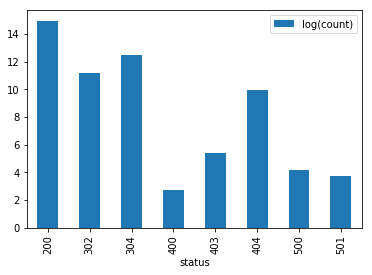

In [57]:
# TODO: Replace <FILL IN> with appropriate code
log_freq_pd_df = log_freq_df.toPandas()
log_freq_pd_df.plot(x='status', y='log(count)', kind='bar')

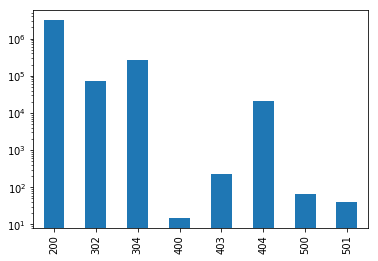

In [62]:
pandas_df['status'].value_counts().sort_index().plot(kind='bar', logy=True)

## Your Turn: Q6: Analyzing Frequent Hosts

Let's look at hosts that have accessed the server frequently. Try to get the count of total accesses by each `host` and then sort by the counts and display only the top ten most frequent hosts.

__Hints:__

- Your Spark DataFrame has a `host` column
- Get the counts per `host` which would make a `count` column
- Sort by the counts. Please check [__the documentation__](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.sort) to see how to sort in reverse
- Remember only to get the top 10 rows from the aggregated dataframe and show them

In [77]:
type(logs_df)

pyspark.sql.dataframe.DataFrame

In [85]:
# TODO: Replace <FILL IN> with appropriate code
from pyspark.sql.functions import desc 

host_sum_df =((logs_df
                     .groupBy('host')
                     .count()
                     .sort(desc('count'))
                     .limit(10)
                     .cache()))
    
host_sum_df.show(truncate=False)

+--------------------+-----+
|host                |count|
+--------------------+-----+
|piweba3y.prodigy.com|21988|
|piweba4y.prodigy.com|16437|
|piweba1y.prodigy.com|12825|
|edams.ksc.nasa.gov  |11964|
|163.206.89.4        |9697 |
|news.ti.com         |8161 |
|www-d1.proxy.aol.com|8047 |
|alyssa.prodigy.com  |8037 |
|                    |7660 |
|siltb10.orl.mmc.com |7573 |
+--------------------+-----+



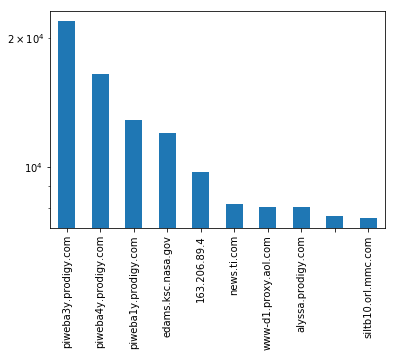

In [92]:
pandas_df['host'].value_counts().nlargest(10).plot(kind='bar', logy=True)

In [86]:
host_sum_pd_df = host_sum_df.toPandas()
host_sum_pd_df.iloc[8]['host']

''

Looks like we have some empty strings as one of the top host names! This teaches us a valuable lesson to not just check for nulls but also potentially empty strings when data wrangling.

## Your Turn: Q7: Display the Top 20 Frequent EndPoints

Now, let's visualize the number of hits to endpoints (URIs) in the log. To perform this task, start with our `logs_df` and group by the `endpoint` column, aggregate by count, and sort in descending order like the previous question. Also remember to show only the top 20 most frequently accessed endpoints

In [97]:
# TODO: Replace <FILL IN> with appropriate code

paths_df = (logs_df
                     .groupBy('endpoint')
                     .count()
                     .sort(desc('count'))
                     .limit(20)
                     .cache())

In [98]:
paths_pd_df = paths_df.toPandas()
paths_pd_df

,endpoint,count
0,/images/NASA-logosmall.gif,208714
1,/images/KSC-logosmall.gif,164970
2,/images/MOSAIC-logosmall.gif,127908
3,/images/USA-logosmall.gif,127074
4,/images/WORLD-logosmall.gif,125925
5,/images/ksclogo-medium.gif,121572
6,/ksc.html,83909
7,/images/launch-logo.gif,76006
8,/history/apollo/images/apollo-logo1.gif,68896
9,/shuttle/countdown/,64736


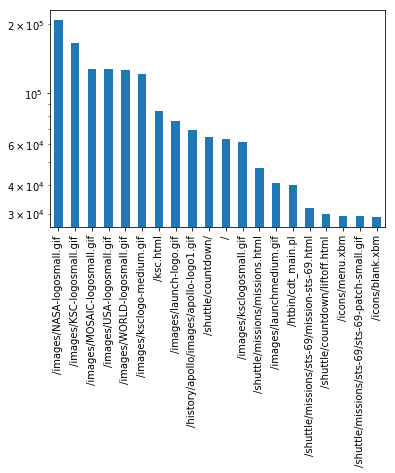

In [96]:
pandas_df['endpoint'].value_counts().nlargest(20).plot(kind='bar', logy=True)

## Your Turn: Q8: Top Ten Error Endpoints

What are the top ten endpoints requested which did not have return code 200 (HTTP Status OK)? 

Create a sorted list containing the endpoints and the number of times that they were accessed with a non-200 return code and show the top ten.

Think about the steps that you need to perform to determine which endpoints did not have a 200 return code (combination of filtering, grouping, sorting and selecting the top ten aggregated records)

In [ ]:
# TODO: Replace <FILL IN> with appropriate code

not200_df = (<FILL IN>)

error_endpoints_freq_df = (not200_df
                               .<FILL IN>
                          )

In [ ]:
error_endpoints_freq_df.show(truncate=False)

## Example: Number of Unique Daily Hosts

For an advanced example, let's look at a way to determine the number of unique hosts in the entire log on a day-by-day basis. This computation will give us counts of the number of unique daily hosts. 

We'd like a DataFrame sorted by increasing day of the month which includes the day of the month and the associated number of unique hosts for that day. 

Think about the steps that you need to perform to count the number of different hosts that make requests *each* day.
*Since the log only covers a single month, you can ignore the month.*  You may want to use the [`dayofmonth` function](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.dayofmonth) in the `pyspark.sql.functions` module (which we have already imported as __`F`__.


**`host_day_df`**

A DataFrame with two columns

| column | explanation          |
| ------ | -------------------- |
| `host` | the host name        |
| `day`  | the day of the month |

There will be one row in this DataFrame for each row in `logs_df`. Essentially, we are just transforming each row of `logs_df`. For example, for this row in `logs_df`:

```
unicomp6.unicomp.net - - [01/Aug/1995:00:35:41 -0400] "GET /shuttle/missions/sts-73/news HTTP/1.0" 302 -
```

your `host_day_df` should have:

```
unicomp6.unicomp.net 1
```

In [ ]:
host_day_df = logs_df.select(logs_df.host, 
                             F.dayofmonth('time').alias('day'))
host_day_df.show(5, truncate=False)

**`host_day_distinct_df`**

This DataFrame has the same columns as `host_day_distinct_df`, but with duplicate (`day`, `host`) rows removed.

In [ ]:
host_day_distinct_df = (host_day_df
                          .dropDuplicates())
host_day_distinct_df.show(5, truncate=False)

**`daily_unique_hosts_df`**

A DataFrame with two columns:

| column  | explanation                                        |
| ------- | -------------------------------------------------- |
| `day`   | the day of the month                               |
| `count` | the number of unique requesting hosts for that day |

In [ ]:
daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .sort("day"))
daily_hosts_df = daily_hosts_df.toPandas()
daily_hosts_df.T

In [ ]:
daily_hosts_df.plot(x='day', y='count', kind='line')

## Your Turn: Q9: Counting 404 Response Codes

Create a DataFrame containing only log records with a 404 status code (Not Found). 

Make sure you `cache()` the `not_found_df` dataframe as we will use it in the rest of the exercises here.

__How many 404 records are in the log?__

In [ ]:
# TODO: Replace <FILL IN> with appropriate code

not_found_df = logs_df.<FILL IN>
print(('Total 404 responses: {}').format(<FILL IN>))

## Your Turn: Q10: Listing the Top Twenty 404 Response Code Endpoints

Using the DataFrame containing only log records with a 404 response code that you cached in Q9, print out a list of the top twenty endpoints that generate the most 404 errors.

*Remember, top endpoints should be in sorted order*

In [ ]:
# TODO: Replace <FILL IN> with appropriate code

hosts_404_count_df = (not_found_df
                          .<FILL IN>)

hosts_404_count_df.show(truncate=False)

## Your Turn: Q11: Visualizing 404 Errors per Day

Let's explore the 404 records temporally now. Similar to the example showing the number of unique daily hosts, break down the 404 requests by day and get the daily counts sorted by day in `errors_by_date_sorted_df`.

- Display the results as a pandas dataframe 
- Also visualize the same dataframe then as a line chart

In [ ]:
# TODO: Replace <FILL IN> with appropriate code

errors_by_date_sorted_df = (not_found_df
                                .<FILL IN>)

errors_by_date_sorted_df = errors_by_date_sorted_df.toPandas()
errors_by_date_sorted_df.T

In [ ]:
errors_by_date_sorted_df.<FILL IN>

## Your Turn: Q12: Visualizing Hourly 404 Errors

Using the DataFrame `not_found_df` you cached in the Q10, group and sort by hour of the day in increasing order, to create a DataFrame containing the total number of 404 responses for HTTP requests for each hour of the day (midnight starts at 0). 

- Remember to check out the [__hour__](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.hour) function and use it (we have already imported __`pyspark.sql.functions`__ as __`F`__ earlier
- Output should be a bar graph displaying the total number of 404 errors per hour

In [ ]:
# TODO: Replace <FILL IN> with appropriate code

hourly_avg_errors_sorted_df = (not_found_df
                                   .<FILL IN>)

In [ ]:
hourly_avg_errors_sorted_df.<FILL IN>